<a href="https://www.kaggle.com/code/wojciech1/a-b-testing-detailed-analysis?scriptVersionId=157589364" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<div style="border-radius:10px; border:#4E5672 solid; padding: 15px; background-color: #F8F1E8; font-size:100%; text-align:left">

<h3 align="left"><font color='#4E5672'>📝 Introduction to the problem:</font></h3>


Cookie Cats is a popular mobile puzzle game developed by Tactile Entertainment. It follows the classic "connect three" puzzle format, where players connect tiles of the same color to clear the board and progress through levels.

As players advance, they encounter gates that either require them to wait for a significant period or make an in-app purchase to continue. These gates not only drive in-app purchases but also serve the purpose of giving players a break from the game, aiming to enhance their overall enjoyment and engagement.

The question at hand is the placement of these gates. Initially set at level 30, we conducted an A/B test in this analysis by moving the first gate from level 30 to level 40 in Cookie Cats. The focus is on evaluating the impact of this change on player retention.

<h3 align="left"><font color='#6B8BA0'>📒 Notebook contents: </font></h3>
This notebook includes A/B testing on a mobile game dataset using bootstraping and null-hypothesis tests from the scipy library.
    
**Dataset:** Mobile Games A/B Testing (https://www.kaggle.com/datasets/yufengsui/mobile-games-ab-testing)


<div style="border-radius:10px; border:#4E5672 solid; padding: 15px; background-color: #F8F1E8; font-size:100%; text-align:left">

<h3 align="left"><font color='#4E5672'>🔧 Data preprocessing</font></h3>

Summary of the section:
* There are **90189 records** split into 2 groups, one with the gate at **level 30** with **44700 records** and one with the gate at **level 40** with **45489 records**
* Looking at the number of rounds played, there is **one clear outlier** with almost **50,000 rounds played** that was excluded from the data

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import statsmodels.stats.api as sms
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

### Data structure

In [2]:
# Read the data
raw_data = pd.read_csv('/kaggle/input/mobile-games-ab-testing/cookie_cats.csv')

# Show the first 5 rows
raw_data.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [3]:
# Display number of records and unique players
print( "Number of records: ", len(raw_data.userid))
print("Number of players: ", raw_data.userid.nunique())

Number of records:  90189
Number of players:  90189


<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FCFAE5; font-size:100%; text-align:left">
<h3 align="left"><font color='#DEB887'>📝 Note</font></h3>
    This dataset contains around <b>90,189 records</b> of players that started the game. The collected variables are:

* **userid** : A unique user number
* **version** : Whether the players were in a group with a gate at level 30 or in a group with the gate at level 40; (When a player installed a game they were randomly assigned to one of the groups)
* **sum_gamerounds** : Number of game rounds played within the first 14 days after installing the game
* **retention_1** : Boolean that defines if the player came back and played 1 day after the installing
* **retention_7** : Boolean that defines if the player came back and played 7 days after the installing

### Data cleaning & consistency

<div style="border-radius:5px; border:#000000 solid; padding: 10px; font-size:120%; text-align:left">
Data types for all of the features align with their purpose, so it doesn't need to be converted. There are no missing values in the data, so it doesn't require erasing rows or imputing values.

In [4]:
# Checking data types of the variables and number of nun-null values in each column
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


### Outliers & normalization

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FCFAE5; font-size:100%; text-align:left">
<h3 align="left"><font color='#DEB887'>📝 Note</font></h3>

* The group with the gate at **level 30** has **44700 records** and the group with the gate at **level 40** has **45489 records**
* The only numeric variable in the dataset is <i>sum_gamerounds</i>. Looking at the distribution of the quartiles, we can notice that the data is comparable and doesn't need normalization
* The group with the gate at level 30 has **one clear outlier with 49854 rounds played** in 14 days after installing the game, where the next highest record is below 3000 rounds

In [5]:
# Comparing the distribution of the number gamerounds played between the 2 groups
raw_data.groupby('version')['sum_gamerounds'].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9, 0.95 ,0.99])

,count,mean,std,min,10%,25%,50%,75%,90%,95%,99%,max
version,,,,,,,,,,,,
gate_30,44700.0,52.456264,256.716423,0.0,1.0,5.0,17.0,50.0,135.0,222.0,493.00,49854.0
gate_40,45489.0,51.298776,103.294416,0.0,1.0,5.0,16.0,52.0,134.0,220.0,492.12,2640.0


In [6]:
# Removing the outlier with 49854 rounds played
data = raw_data[raw_data['sum_gamerounds']!=49854]
data.groupby('version')['sum_gamerounds'].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9, 0.95 ,0.99])

,count,mean,std,min,10%,25%,50%,75%,90%,95%,99%,max
version,,,,,,,,,,,,
gate_30,44699.0,51.342111,102.057598,0.0,1.0,5.0,17.0,50.0,135.0,222.0,493.00,2961.0
gate_40,45489.0,51.298776,103.294416,0.0,1.0,5.0,16.0,52.0,134.0,220.0,492.12,2640.0


<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FCFAE5; font-size:100%; text-align:left">
<h3 align="left"><font color='#DEB887'>📝 Note</font></h3>

After the initial preprocessing we got the following conclusions about the variables:

* **userid**: Discrete variable, stored as integer; each record has a unique number 
* **version**: Nominal variable, stored as string; shows which version of the game a player had
* **sum_gamerounds**: Discrete variable, stored as integer; shows how many levels a user played
* **retention_1** Nominal variable, stored as boolean, shows if a user played the game on the first day after installing
* **retention_7** Nominal variable, stored as boolean, shows if a user played the game 7 days after installing
    

<div style="border-radius:10px; border:#4E5672 solid; padding: 15px; background-color: #F8F1E8; font-size:100%; text-align:left">

<h3 align="left"><font color='#4E5672'>📊 Exploratory Analysis</font></h3>
    
Summary of the section:
    
* Most users (99%) play less than 500 rounds in the first 14 days and for those who played more changing the gate at level 30 shouldn't change their retention, hence they are excluded from the retention analysis
* Similarly, players with less than 30 rounds played were excluded as they can't reach the first gate and moving it to level 40 has no effect on their experience in the game

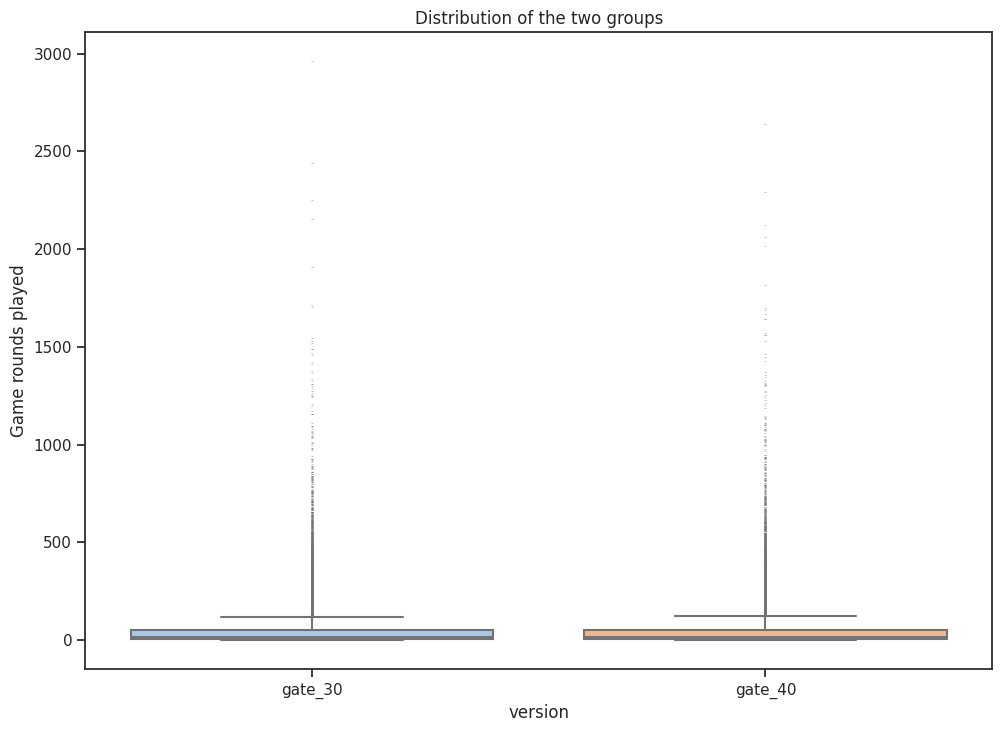

In [7]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_theme(style="ticks", palette="pastel")
sns.boxplot(x="version", y="sum_gamerounds", fliersize=0.1, data=data).set(title="Distribution of the two groups", ylabel="Game rounds played");

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FCFAE5; font-size:100%; text-align:left">
<h3 align="left"><font color='#DEB887'>📝 Note</font></h3>

* Around **4000 users installed the game, but didn't play a single round**
* The number of users quite quickly for the first c.100 rounds, meaning most users didn't progress past the early levels
    * A lot of players didn't play 30 rounds, meaning they couldn't reach the first gate and moving it shouldn't affect their experience
    * Similarly, players who played a lot of rounds probably reached level far beyond the first gate and moving it shouldn't affect their retention

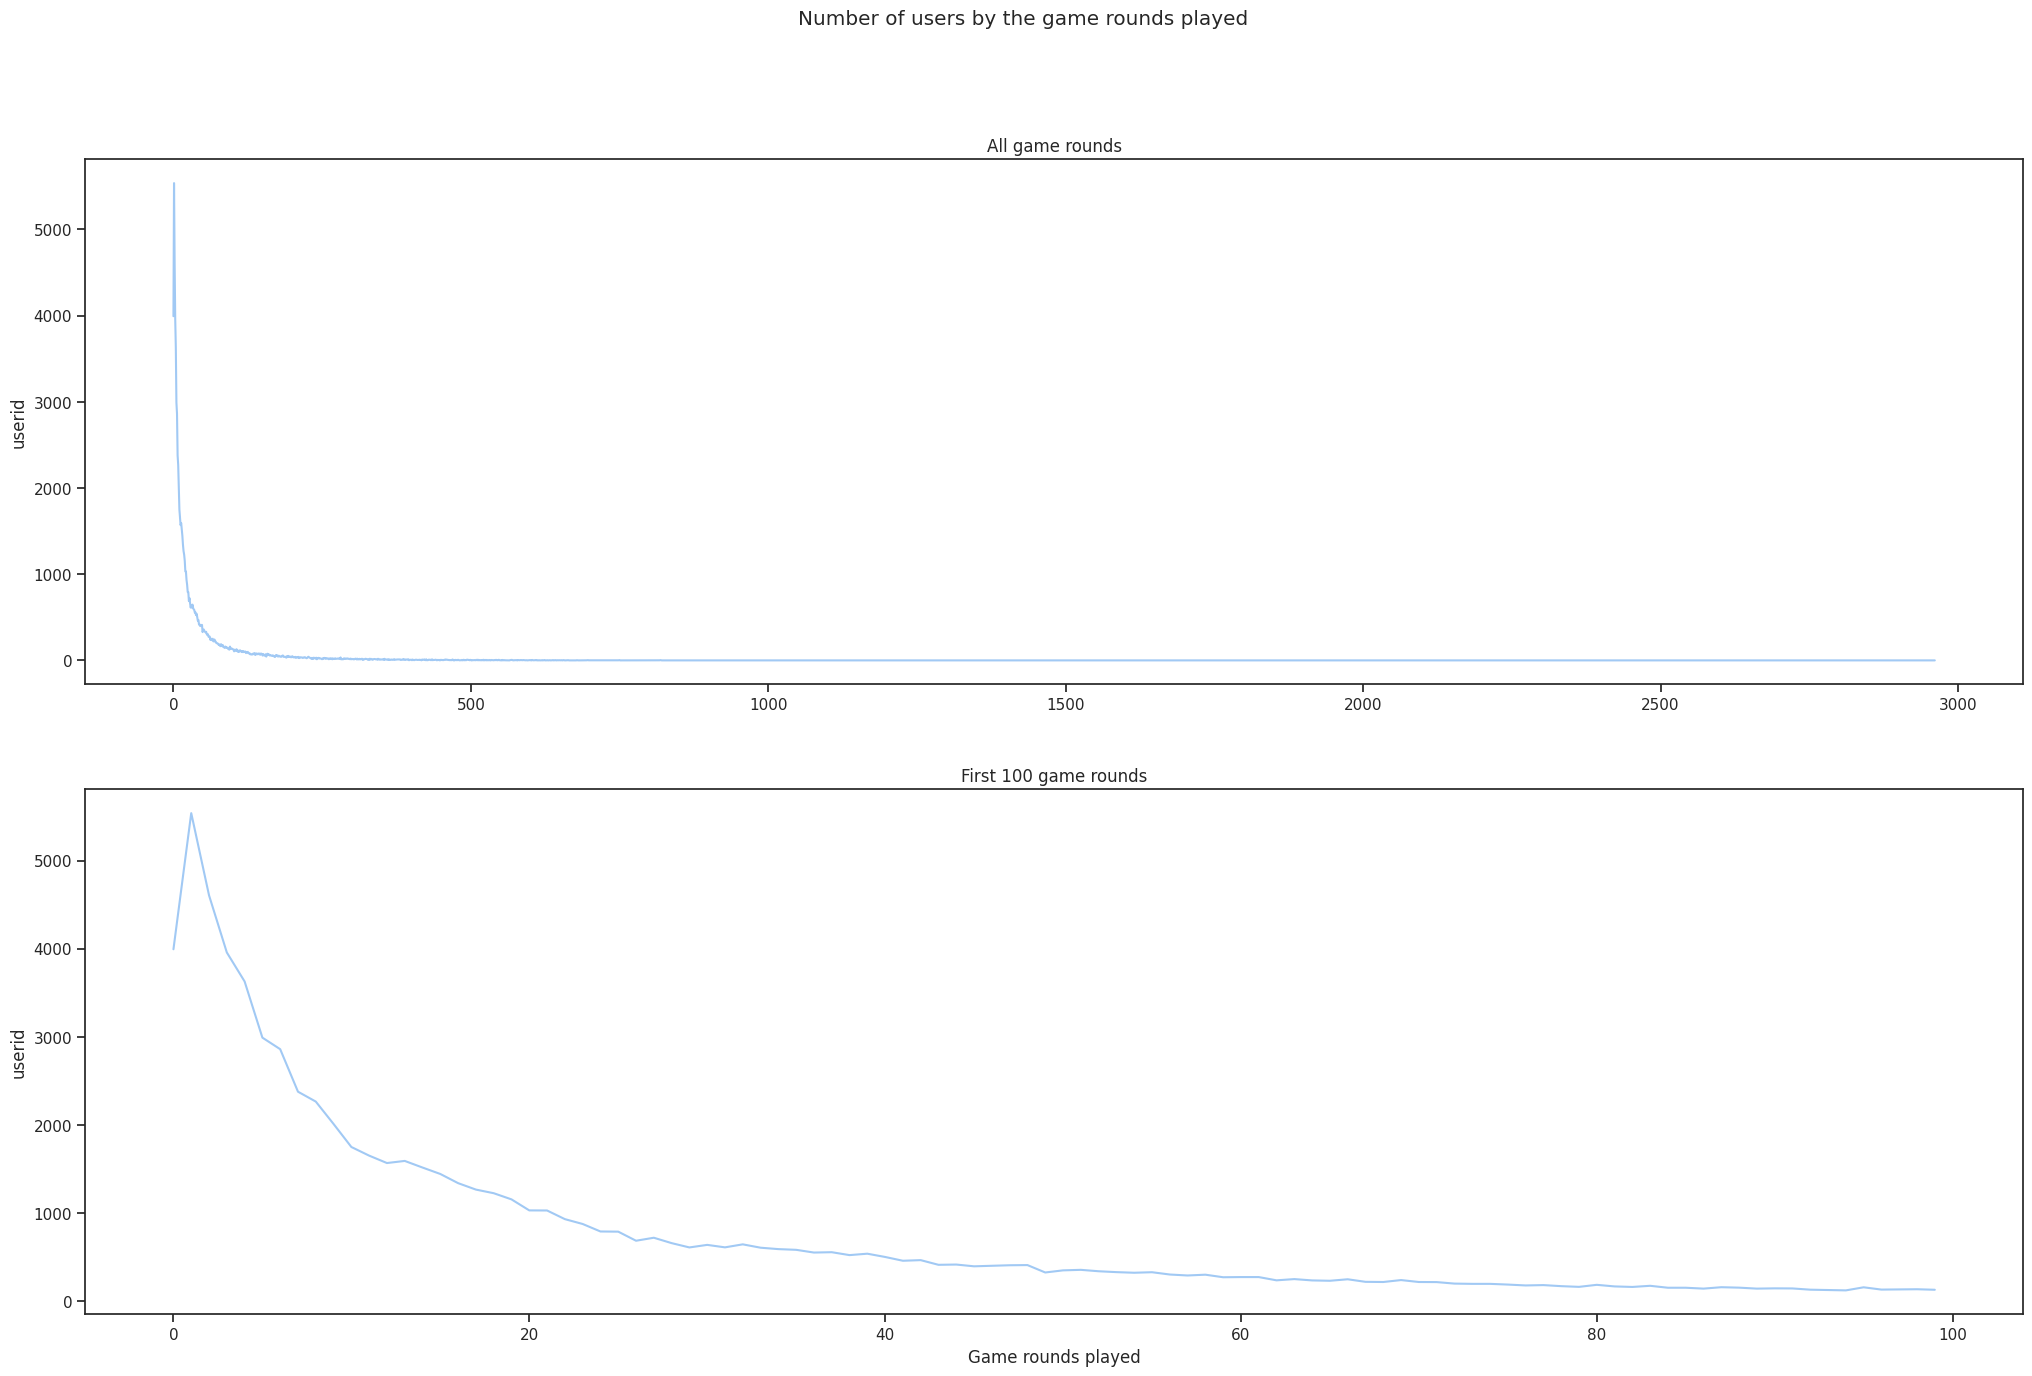

In [8]:
# Creating figure and adding plot title
fig, ax = plt.subplots(2, 1, figsize = (25,15))
plt.suptitle("Number of users by the game rounds played")

# Creating plots with titles
rounds_plot = data.groupby('sum_gamerounds')['userid'].count()
sns.lineplot(data=rounds_plot, ax=ax[0]).set(title="All game rounds", xlabel='');
sns.lineplot(data=rounds_plot[:100], ax=ax[1]).set(title="First 100 game rounds", xlabel='Game rounds played');

In [9]:
# Using the 99th percentile from preprocessing, separating the top 1% of players by the number of rounds, users who played less than 30 rounds and users who played between 30-500 rounds
less_than_30_rounds = data[data['sum_gamerounds']<30]
no_outliers = data[data['sum_gamerounds'].between(30, 500)]
top_players = data[data['sum_gamerounds']>=500]

In [10]:
# Showing the distribution of the players included in the retention analysis
no_outliers.groupby('version')['sum_gamerounds'].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9, 0.95 ,0.99])

,count,mean,std,min,10%,25%,50%,75%,90%,95%,99%,max
version,,,,,,,,,,,,
gate_30,16229.0,106.256947,91.435026,30.0,35.0,43.0,70.0,135.0,233.2,313.0,440.0,500.0
gate_40,16184.0,107.830573,90.478331,30.0,35.0,46.0,73.0,136.0,234.7,313.0,440.0,500.0


In [11]:
# Comparing the average retention between the top 1% players and the other 99% of players
less_than_30_retention = 100*less_than_30_rounds['retention_7'].sum()/less_than_30_rounds.shape[0]
no_outliers_retention = 100*no_outliers['retention_7'].sum()/no_outliers.shape[0]
top_players_retention = 100*top_players['retention_7'].sum()/top_players.shape[0]
print("7 day retention for players with less than 30 rounds played: {}%. Number of players: {}".format(round(less_than_30_retention,1), less_than_30_rounds.shape[0]))
print("7 day retention for players with 30-500 rounds played: {}%. Number of players: {}".format(round(no_outliers_retention,1), no_outliers.shape[0]))
print("7 day retention for players with more than 500 rounds played: {}%. Number of players: {}".format(round(top_players_retention,1), top_players.shape[0]))

7 day retention for players with less than 30 rounds played: 4.1%. Number of players: 56920
7 day retention for players with 30-500 rounds played: 42.1%. Number of players: 32413
7 day retention for players with more than 500 rounds played: 95.6%. Number of players: 859


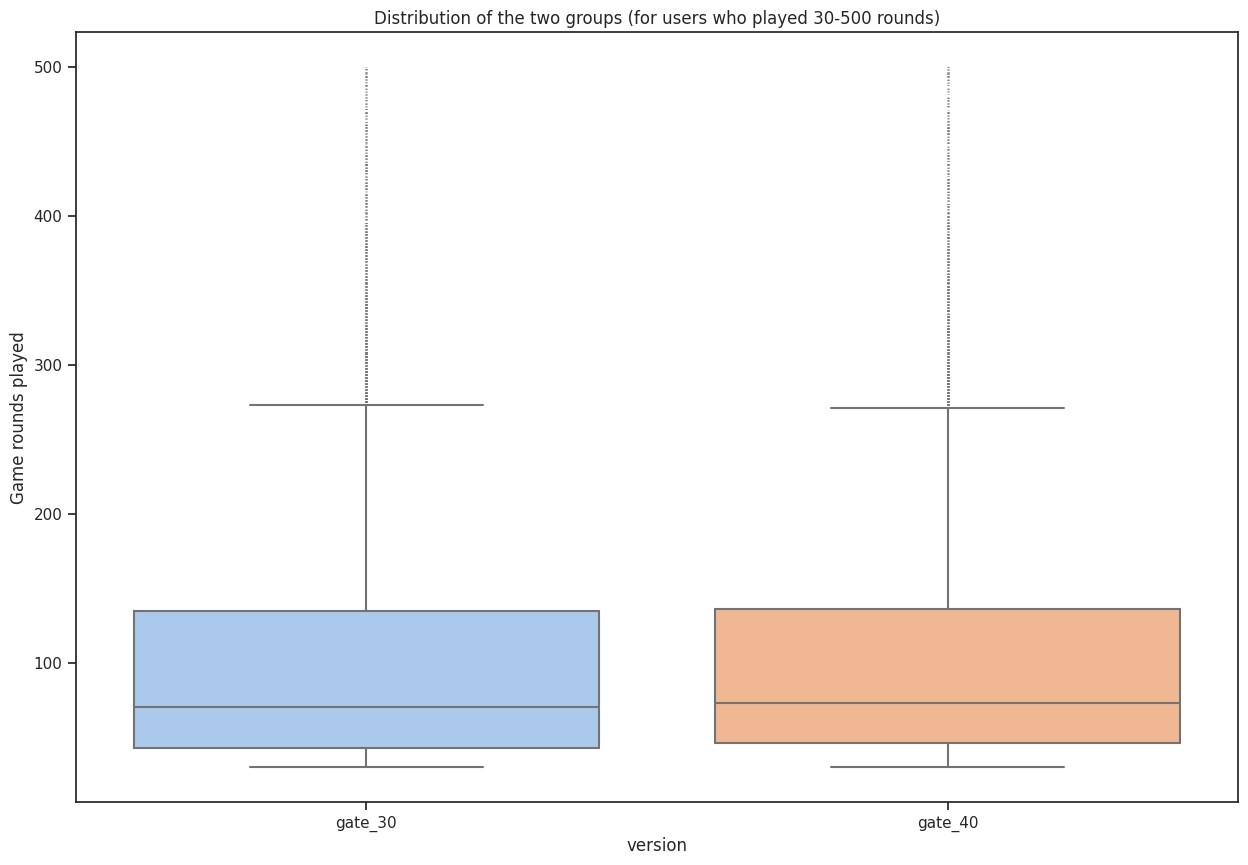

In [12]:
sns.set(rc={'figure.figsize':(15,10)})
sns.set_theme(style="ticks", palette="pastel")
sns.boxplot(x="version", y="sum_gamerounds", fliersize=0.1, data=no_outliers).set(title="Distribution of the two groups (for users who played 30-500 rounds)", ylabel="Game rounds played");

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FCFAE5; font-size:100%; text-align:left">
<h3 align="left"><font color='#DEB887'>📝 Note</font></h3>
    
**Most users (99%) play less than 500 rounds in the first 14 days and for those who played more changing the gate at level 30 shouldn't change their retention, hence they are excluded from the retention analysis. Similarly, players with less than 30 rounds played were excluded as they can't reach the first gate and moving it to level 40 has no effect on their experience in the game**

<div style="border-radius:10px; border:#4E5672 solid; padding: 15px; background-color: #F8F1E8; font-size:100%; text-align:left">

<h3 align="left"><font color='#4E5672'>🔍 A/B Testing</font></h3>
   
We will use AB testing to analyse if moving the gate from level 30 to level 40 had an effect on 1-day and 7-day user retention and the average number of rounds played.
* The control group are the users with gate at level 30 and the test group are users with the gate at level 40
    * The test were done separately on the top 1% players and users who played between 30 and 500 rounds
    * Users who played less than 30 rounds were excluded from the analysis, as they couldn't have reached level 30 and changing the gate had no effect on their experience
* The test for the retention rate will be done by bootstrapping a number of samples from our dataset (separately for the control and test groups) and comparing the distribution of possible retention rates
* The test for the average number of rounds played will be done using a non-parametric MannWhitneyu test, as the rounds played variable doesn't follow a normal distribution

**Results summary:**
* In the 30-500 rounds group changing the gate resulted in:
    * No statistically significant difference in 1-day retention
    * A small increase in 7-day retention (~0.01 ppt)
    * A small increase in the number of games played (~1 round)
* In the top 1% of users changing the gate resulted in:
    * No significant difference in 1-day retention
    * A small decrease in 7-day retention (~0.015 ppt)
    * An increase in the number of games played (~25 rounds), which may not be statistcally significant and would need further testing

<div style="border-radius:10px; border:#D0C2F0 solid; padding: 15px; background-color: #FFF0F4; font-size:100%; text-align:left">

<h3 align="left"><font color='#5E5273'>🔍 Initial Hypothesis</font></h3>

* **H₀**: Moving the Time Gate from Level 30 to Level 40 doesn't change user retention.
    
* **H₁**: Moving the Time Gate from Level 30 to Level 40 will change user retention.

<div style="border-radius:10px; border:#D0C2F0 solid; padding: 15px; background-color: #FFF0F4; font-size:100%; text-align:left">

<h3 align="left"><font color='#5E5273'>⚙️ Bootstrapping</font></h3>

We use bootstrapping to determinte whether the differences in the player retention is due to chance or the change in the game version. For this to work we need to assume that our data sample is representative of the entire population. Since the sample is large, has users who played a large range of rounds and the distribution of users by number of rounds played is sensible it seems the sample should be representative of the population.
    
**Steps in bootsrapping**
* First we choose how how many samples we want to draw (in this case n=5000)
* Then we draw n samples with replacement from the data, each with the same length as the data itself
* For each sample we calculate the retention rate and save it in the list
* Then for each of the samples we take the difference in retention, plot the distribution and calculate the proportions of the samples where control group has higher retention

### Functions for bootstrapping and printing test statistic summary

In [13]:
# Bootstrapping function for retention
def bootstrapping(data, iterations=1):
    boot_retention = []
    for i in range(iterations):
        boot_data = np.random.choice(data, int(len(data)))
        boot_retention.append(boot_data.mean())
    return boot_retention

In [14]:
# Function that summarises test result based on the test used and p value and threshold
def print_summary(stat_test, p_val, threshold):
        
    # Data frame to store the results
    temp = pd.DataFrame(data={"Test": stat_test, "Test threshold": threshold, "p value": "{:.2g}".format(p_val)}, index=[0])
    
    # Determining if test rejected initial hypothesis
    if p_val < threshold:
        temp["Result"] = "Reject H0"
        temp["Comment"] = "Control and test groups are not from the same distribution"
    else:
        temp["Result"] = "Can't reject H0"
        temp["Comment"] = "Control and test groups may come from the same distribion"

    temp = temp[["Test","Result", "p value", "Test threshold", "Comment"]]
    
    # Print tested hypothesis
    print("Test hypothesis")
    print("H0: A == B")
    print("H1: A != B", "\n")
    
    return temp

## Users with 30-500 rounds played

### Splitting the data into control and test groups

In [15]:
control_7 = no_outliers[no_outliers['version'] == 'gate_30']['retention_7']
test_7 = no_outliers[no_outliers['version'] == 'gate_40']['retention_7']
control_1 = no_outliers[no_outliers['version'] == 'gate_30']['retention_1']
test_1 = no_outliers[no_outliers['version'] == 'gate_40']['retention_1']
control_rounds = no_outliers[no_outliers['version'] == 'gate_30']['sum_gamerounds']
test_rounds = no_outliers[no_outliers['version'] == 'gate_40']['sum_gamerounds']

In [16]:
print("The average 7-day retention for group with gate at level 30: {}%".format(round(100*control_7.mean(),1)))
print("The average 7-day retention for group with gate at level 40: {}%".format(round(100*test_7.mean(),1)))

The average 7-day retention for group with gate at level 30: 42.5%
The average 7-day retention for group with gate at level 40: 41.6%


In [17]:
print("The average 1-day retention for group with gate at level 30: {}%".format(round(100*control_1.mean(),1)))
print("The average 1-day retention for group with gate at level 40: {}%".format(round(100*test_1.mean(),1)))

The average 1-day retention for group with gate at level 30: 79.6%
The average 1-day retention for group with gate at level 40: 79.7%


### Bootstrapping for retention testing

The probabilty of control group (gate at level 30) having a higher 1 day retention than test group (gate at level 40) is: ~ 55.6% 
 The difference in the average 1 day retention between control and test group is -0.001%


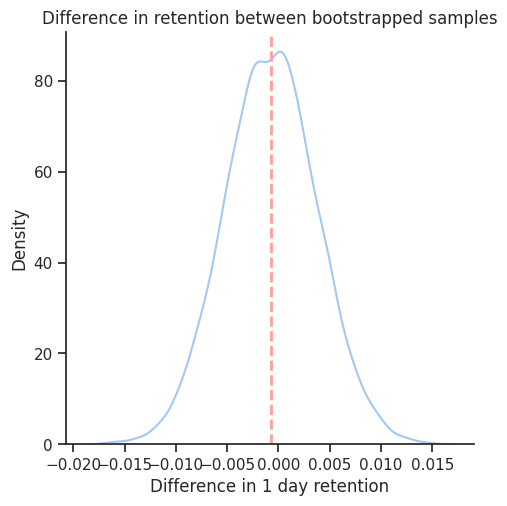

In [18]:
# Creating a list with bootstrapped means for 1 day retention each A/B-group

# Bootstrapping for control group
boot_contr_1 = bootstrapping(control_1, iterations = 5000)

# Bootstrapping for test group
boot_test_1 = bootstrapping(test_1, iterations = 5000)

boot_1 = pd.DataFrame(data = {'gate_30':boot_contr_1, 'gate_40':boot_test_1},
                       index = range(5000))

# Adding a column with the % difference between the two AB-groups
boot_1['diff'] = boot_1['gate_30'] - boot_1['gate_40']

# Ploting the bootstrap % difference
sns.displot(boot_1['diff'], kind="kde").set(title="Difference in retention between bootstrapped samples", xlabel="Difference in 1 day retention")
plt.axvline(boot_1['diff'].mean(), c='r', ls='--', lw=2.0)

# Calculating the probability of drawing a sample with a higher 1 day retention when the gate is at level 30
prob = (boot_1['diff'] < 0).sum() / len(boot_1)

# Showing the probability
print('The probabilty of control group (gate at level 30) having a higher 1 day retention than test group (gate at level 40) is: ~ {}% \n The difference in the average 1 day retention between control and test group is {}%'.format(round(prob*100,1), round(boot_1['diff'].mean(),3)))

The probabilty of control group (gate at level 30) having a higher 7 day retention than test group (gate at level 40) is: ~ 96.0%
The difference in the average 7 day retention between control and test group is 0.009%


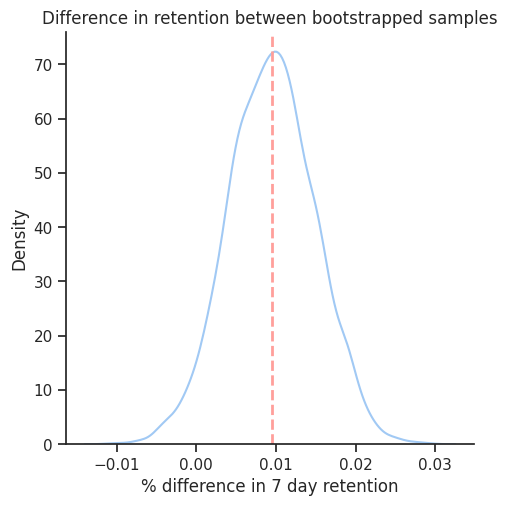

In [19]:
# Creating a list with bootstrapped means for 7 day retention each A/B-group

# Bootstrapping for control group
boot_contr_7 = bootstrapping(control_7, iterations = 5000)

# Bootstrapping for test group
boot_test_7 = bootstrapping(test_7, iterations = 5000)

boot_7 = pd.DataFrame(data = {'gate_30':boot_contr_7, 'gate_40':boot_test_7},
                       index = range(5000))

# Adding a column with the % difference between the two AB-groups
boot_7['diff'] = boot_7['gate_30'] - boot_7['gate_40']

# Ploting the bootstrap % difference
sns.displot(boot_7['diff'], kind="kde").set(title="Difference in retention between bootstrapped samples", xlabel="% difference in 7 day retention")
plt.axvline(boot_7['diff'].mean(), c='r', ls='--', lw=2.0)

# Calculating the probability of drawing a sample with a higher 7-day retention when the gate is at level 30
prob = (boot_7['diff'] > 0).sum() / len(boot_7)

# Showing the probability
print('The probabilty of control group (gate at level 30) having a higher 7 day retention than test group (gate at level 40) is: ~ {}%\nThe difference in the average 7 day retention between control and test group is {}%'.format(round(prob*100,1), round(boot_7['diff'].mean(),3)))

### MannWhitneyu test on the number of game rounds played

In [20]:
print("The average number of rouds played for group with gate at level 30: {}".format(int(control_rounds.mean())))
print("The average number of rouds played for group with gate at level 40: {}".format(int(test_rounds.mean())))

The average number of rouds played for group with gate at level 30: 106
The average number of rouds played for group with gate at level 40: 107


In [21]:
# Testing if changing the gate affects the number of rounds played by users
test = stats.mannwhitneyu(control_rounds, test_rounds)
print_summary("MannWhitneyu", test[1], 0.05)

Test hypothesis
H0: A == B
H1: A != B 



,Test,Result,p value,Test threshold,Comment
0,MannWhitneyu,Reject H0,6.7e-05,0.05,Control and test groups are not from the same ...


## Top 1% of players

### Splitting the data into control and test groups

In [22]:
control_top_1 = top_players[top_players['version'] == 'gate_30']['retention_1']
test_top_1 = top_players[top_players['version'] == 'gate_40']['retention_1']
control_top_7 = top_players[top_players['version'] == 'gate_30']['retention_7']
test_top_7 = top_players[top_players['version'] == 'gate_40']['retention_7']
control_top_rounds = top_players[top_players['version'] == 'gate_30']['sum_gamerounds']
test_top_rounds = top_players[top_players['version'] == 'gate_40']['sum_gamerounds']

In [23]:
print("The average 1-day retention for group with gate at level 30: {}%".format(round(100*control_top_1.mean(),1)))
print("The average 1-day retention for group with gate at level 40: {}%".format(round(100*test_top_1.mean(),1)))

The average 1-day retention for group with gate at level 30: 97.4%
The average 1-day retention for group with gate at level 40: 97.7%


In [24]:
print("The average 7-day retention for group with gate at level 30: {}%".format(round(100*control_top_7.mean(),1)))
print("The average 7-day retention for group with gate at level 40: {}%".format(round(100*test_top_7.mean(),1)))

The average 7-day retention for group with gate at level 30: 94.8%
The average 7-day retention for group with gate at level 40: 96.3%


### Bootstrapping for retention testing

The probabilty of control group (gate at level 30) having a higher 1 day retention than test group (gate at level 40) is: ~ 37.0% 
 The difference in the average 1 day retention between control and test group is -0.002%


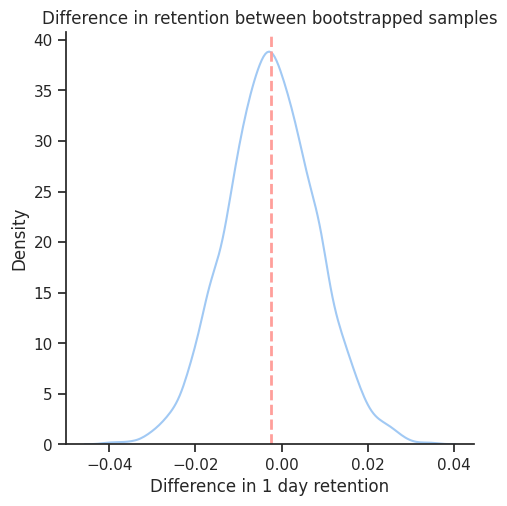

In [25]:
# Creating a list with bootstrapped means for 1 day retention each A/B-group

# Bootstrapping for control group
boot_contr_1 = bootstrapping(control_top_1, iterations = 5000)

# Bootstrapping for test group
boot_test_1 = bootstrapping(test_top_1, iterations = 5000)

boot_1 = pd.DataFrame(data = {'gate_30':boot_contr_1, 'gate_40':boot_test_1},
                       index = range(5000))

# Adding a column with the % difference between the two AB-groups
boot_1['diff'] = boot_1['gate_30'] - boot_1['gate_40']

# Ploting the bootstrap % difference
sns.displot(boot_1['diff'], kind="kde").set(title="Difference in retention between bootstrapped samples", xlabel="Difference in 1 day retention")
plt.axvline(boot_1['diff'].mean(), c='r', ls='--', lw=2.0)

# Calculating the probability of drawing a sample with a higher 1 day retention when the gate is at level 30
prob = (boot_1['diff'] > 0).sum() / len(boot_1)

# Showing the probability
print('The probabilty of control group (gate at level 30) having a higher 1 day retention than test group (gate at level 40) is: ~ {}% \n The difference in the average 1 day retention between control and test group is {}%'.format(round(prob*100,1), round(boot_1['diff'].mean(),3)))

The probabilty of control group (gate at level 30) having a higher 1 day retention than test group (gate at level 40) is: ~ 13.8% 
 The difference in the average 1 day retention between control and test group is -0.014%


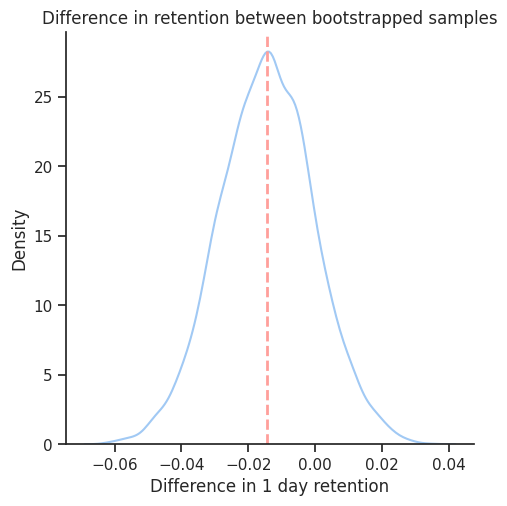

In [26]:
# Creating a list with bootstrapped means for 1 day retention each A/B-group

# Bootstrapping for control group
boot_contr_1 = bootstrapping(control_top_7, iterations = 5000)

# Bootstrapping for test group
boot_test_1 = bootstrapping(test_top_7, iterations = 5000)

boot_1 = pd.DataFrame(data = {'gate_30':boot_contr_1, 'gate_40':boot_test_1},
                       index = range(5000))

# Adding a column with the % difference between the two AB-groups
boot_1['diff'] = boot_1['gate_30'] - boot_1['gate_40']

# Ploting the bootstrap % difference
sns.displot(boot_1['diff'], kind="kde").set(title="Difference in retention between bootstrapped samples", xlabel="Difference in 1 day retention")
plt.axvline(boot_1['diff'].mean(), c='r', ls='--', lw=2.0)

# Calculating the probability of drawing a sample with a higher 1 day retention when the gate is at level 30
prob = (boot_1['diff'] > 0).sum() / len(boot_1)

# Showing the probability
print('The probabilty of control group (gate at level 30) having a higher 1 day retention than test group (gate at level 40) is: ~ {}% \n The difference in the average 1 day retention between control and test group is {}%'.format(round(prob*100,1), round(boot_1['diff'].mean(),3)))

### MannWhitneyu test on the number of game rounds played

In [27]:
print("The average number of rouds played for group with gate at level 30: {}".format(int(control_top_rounds.mean())))
print("The average number of rouds played for group with gate at level 40 {}".format(int(test_top_rounds.mean())))

The average number of rouds played for group with gate at level 30: 724
The average number of rouds played for group with gate at level 40 750


In [28]:
# Testing if changing the gate affects the number of rounds played by top 1% of users
test = stats.mannwhitneyu(control_top_rounds, test_top_rounds)
print_summary("MannWhitneyu", test[1], 0.05)

Test hypothesis
H0: A == B
H1: A != B 



,Test,Result,p value,Test threshold,Comment
0,MannWhitneyu,Can't reject H0,0.098,0.05,Control and test groups may come from the same...


<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FCFAE5; font-size:100%; text-align:left">
<h3 align="left"><font color='#DEB887'>📝 Conclusion</font></h3>
    
Based on the AB testing conducted to analyze the impact of moving the gate from level 30 to level 40 on 1-day and 7-day user retention, as well as the average number of rounds played, the following conclusions can be drawn:

**Users Playing Between 30 and 500 Rounds:**

* 1-day Retention: There was no statistically significant difference observed in 1-day retention between the control group (gate at level 30) and the test group (gate at level 40).
* 7-day Retention: A small, but statistically significant, increase of approximately 0.01 percentage points (ppt) was observed in 7-day retention for the test group.
* Average Rounds Played: The test group showed a small increase of approximately 1 round in the average number of games played. This change was statistically significant
    
**Top 1% of Users:**

* 1-day Retention: No statistically significant difference was observed in 1-day retention between the control and test groups for the top 1% of users
* 7-day Retention: A small, decrease of approximately 0.015 ppt was observed in 7-day retention for the test group. However, this decrease may not be statistically significant and warrants further testing
* Average Rounds Played: An increase of approximately 25 rounds in the number of games played was observed in the test group. However, this increase may not be statistically significant and warrants further testing
    
In summary, for users playing between 30 and 500 rounds, the change in the gate from level 30 to level 40 resulted in a small but statistically significant improvement in 7-day retention and the average number of rounds played. However, for the top 1% of users, the impact on 7-day retention and the number of games played needs further investigation is needed to confirm the observed changes. Overall, the gate adjustment appears to have a positive effect on user engagement within certain user segments, emphasizing the importance of segment-specific analysis in interpreting AB testing results.